In [1]:
# %%capture cap
!pip install -q ipywidgets
!pip install -q autogluon scikit-learn==1.5.2 
!apt-get install -q -y graphviz graphviz-dev && pip install -q pydot
!pip install -q pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.9/454.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/189.7 kB 9.2 MB/s eta 0:00:

In [2]:
import torch
import os
import pydot

import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from time import time, sleep
from itertools import combinations

from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

pd.set_option('display.max_columns', 500)
# plt.style.use("ggplot")
# sns.set_style("whitegrid")

## -- Ansi color codes --
COLOR = '\033[32m'
RESET = '\033[0m'

In [3]:
### Load Data ###
PATH = "/kaggle/input/playground-series-s5e11/"
submit = pd.read_csv(PATH+"sample_submission.csv")

TARGET = "loan_paid_back"
train = pd.read_csv(PATH+"train.csv").drop(['id', TARGET], axis=1)
test = pd.read_csv(PATH+"test.csv").drop(['id'], axis=1)

NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
BASE = NUMS + CATS

ORIG_PATH = "/kaggle/input/loan-prediction-dataset-2025/"
orig = pd.read_csv(ORIG_PATH+"loan_dataset_20000.csv")[BASE+[TARGET]]

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (593994, 11)
Test shape: (254569, 11)
Original shape: (20000, 12)

Total Numerical: 5
Total Categorical: 6
Total base features: 11


In [4]:
## -- Define categories for OHE --
CAT_COLS = [c for c in BASE if train[c].dtype=='object' or train[c].nunique() <= 0.01*len(train)]
print(f"ℹ️ Features for TE: {len(CAT_COLS)} -> {CAT_COLS}")

ℹ️ Features for TE: 9 -> ['debt_to_income_ratio', 'credit_score', 'interest_rate', 'gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']


In [5]:
ROUND = []
for col in tqdm(['annual_income', 'loan_amount']):
    for r in [-3, -2, -1, 0]:
        n = f"{col}_r{r}"
        train[n] = train[col].round(r).astype(int)
        test[n] = test[col].round(r).astype(int)
        orig[n] = test[col].round(r).astype(int)
        ROUND.append(n)

print(f'{len(ROUND)} ROUND Features created.')
print(train[ROUND].nunique())

DIGITS = []
for col in tqdm(['debt_to_income_ratio']):
    for d in range(1, 4):
        n = f'{col}_d{d}'
        train[n] = ((train[col] * 10**d) % 10).fillna(-1).astype(int)
        test[n]  = ((test[col]  * 10**d) % 10).fillna(-1).astype(int)
        orig[n]  = ((orig[col]  * 10**d) % 10).fillna(-1).astype(int)

        ## -- Drop constant features --
        if train[n].nunique() < 2:
            train.drop([n], axis=1, inplace=True)
            test.drop([n],  axis=1, inplace=True)
            orig.drop([n],  axis=1, inplace=True)
        else:
            DIGITS.append(n)

for col in tqdm(['interest_rate']):
    for d in range(1, 3):
        n = f'{col}_d{d}'
        train[n] = ((train[col] * 10**d) % 10).fillna(-1).astype(int)
        test[n]  = ((test[col]  * 10**d) % 10).fillna(-1).astype(int)
        orig[n]  = ((orig[col]  * 10**d) % 10).fillna(-1).astype(int)

        ## -- Drop constant features --
        if train[n].nunique() < 2:
            train.drop([n], axis=1, inplace=True)
            test.drop([n],  axis=1, inplace=True)
            orig.drop([n],  axis=1, inplace=True)
        else:
            DIGITS.append(n)

print(f'{len(DIGITS)} Features DIGITS extracted.')
print(train[DIGITS].nunique())

INTER = []
for col1, col2 in tqdm(list(combinations(CAT_COLS+DIGITS, 2)), desc="Pairwise"):
    new_col = f"{col1}-|-{col2}"
    train[new_col] = train[col1].astype(str) + '_' + train[col2].astype(str)
    test[new_col] = test[col1].astype(str) + '_' + test[col2].astype(str)
    orig[new_col] = orig[col1].astype(str) + '_' + orig[col2].astype(str)
    INTER.append(new_col)

print(f"Ineraction Features: {len(INTER)}")

  0%|          | 0/2 [00:00<?, ?it/s]

8 ROUND Features created.
annual_income_r-3      270
annual_income_r-2     1721
annual_income_r-1     9706
annual_income_r0     35523
loan_amount_r-3         49
loan_amount_r-2        426
loan_amount_r-1       3558
loan_amount_r0       21644
dtype: int64


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

5 Features DIGITS extracted.
debt_to_income_ratio_d1     7
debt_to_income_ratio_d2    10
debt_to_income_ratio_d3    10
interest_rate_d1           10
interest_rate_d2           10
dtype: int64


Pairwise:   0%|          | 0/91 [00:00<?, ?it/s]

Ineraction Features: 91


In [6]:
## -- Factorize using combined data --
combined = pd.concat([train, test, orig], ignore_index=True)

for c in CATS + DIGITS + INTER:
    combined[c] = combined[c].astype("category")

train = combined[:len(train)]
test  = combined[len(train):len(train)+len(test)]
orig  = combined[-len(orig):]

print('Category creation complete!')
orig.shape, train.shape, test.shape

Category creation complete!


((20000, 116), (593994, 116), (254569, 116))

In [7]:
display(train.head())
# train.info()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,annual_income_r-3,annual_income_r-2,annual_income_r-1,annual_income_r0,loan_amount_r-3,loan_amount_r-2,loan_amount_r-1,loan_amount_r0,debt_to_income_ratio_d1,debt_to_income_ratio_d2,debt_to_income_ratio_d3,interest_rate_d1,interest_rate_d2,debt_to_income_ratio-|-credit_score,debt_to_income_ratio-|-interest_rate,debt_to_income_ratio-|-gender,debt_to_income_ratio-|-marital_status,debt_to_income_ratio-|-education_level,debt_to_income_ratio-|-employment_status,debt_to_income_ratio-|-loan_purpose,debt_to_income_ratio-|-grade_subgrade,debt_to_income_ratio-|-debt_to_income_ratio_d1,debt_to_income_ratio-|-debt_to_income_ratio_d2,debt_to_income_ratio-|-debt_to_income_ratio_d3,debt_to_income_ratio-|-interest_rate_d1,debt_to_income_ratio-|-interest_rate_d2,credit_score-|-interest_rate,credit_score-|-gender,credit_score-|-marital_status,credit_score-|-education_level,credit_score-|-employment_status,credit_score-|-loan_purpose,credit_score-|-grade_subgrade,credit_score-|-debt_to_income_ratio_d1,credit_score-|-debt_to_income_ratio_d2,credit_score-|-debt_to_income_ratio_d3,credit_score-|-interest_rate_d1,credit_score-|-interest_rate_d2,interest_rate-|-gender,interest_rate-|-marital_status,interest_rate-|-education_level,interest_rate-|-employment_status,interest_rate-|-loan_purpose,interest_rate-|-grade_subgrade,interest_rate-|-debt_to_income_ratio_d1,interest_rate-|-debt_to_income_ratio_d2,interest_rate-|-debt_to_income_ratio_d3,interest_rate-|-interest_rate_d1,interest_rate-|-interest_rate_d2,gender-|-marital_status,gender-|-education_level,gender-|-employment_status,gender-|-loan_purpose,gender-|-grade_subgrade,gender-|-debt_to_income_ratio_d1,gender-|-debt_to_income_ratio_d2,gender-|-debt_to_income_ratio_d3,gender-|-interest_rate_d1,gender-|-interest_rate_d2,marital_status-|-education_level,marital_status-|-employment_status,marital_status-|-loan_purpose,marital_status-|-grade_subgrade,marital_status-|-debt_to_income_ratio_d1,marital_status-|-debt_to_income_ratio_d2,marital_status-|-debt_to_income_ratio_d3,marital_status-|-interest_rate_d1,marital_status-|-interest_rate_d2,education_level-|-employment_status,education_level-|-loan_purpose,education_level-|-grade_subgrade,education_level-|-debt_to_income_ratio_d1,education_level-|-debt_to_income_ratio_d2,education_level-|-debt_to_income_ratio_d3,education_level-|-interest_rate_d1,education_level-|-interest_rate_d2,employment_status-|-loan_purpose,employment_status-|-grade_subgrade,employment_status-|-debt_to_income_ratio_d1,employment_status-|-debt_to_income_ratio_d2,employment_status-|-debt_to_income_ratio_d3,employment_status-|-interest_rate_d1,employment_status-|-interest_rate_d2,loan_purpose-|-grade_subgrade,loan_purpose-|-debt_to_income_ratio_d1,loan_purpose-|-debt_to_income_ratio_d2,loan_purpose-|-debt_to_income_ratio_d3,loan_purpose-|-interest_rate_d1,loan_purpose-|-interest_rate_d2,grade_subgrade-|-debt_to_income_ratio_d1,grade_subgrade-|-debt_to_income_ratio_d2,grade_subgrade-|-debt_to_income_ratio_d3,grade_subgrade-|-interest_rate_d1,grade_subgrade-|-interest_rate_d2,debt_to_income_ratio_d1-|-debt_to_income_ratio_d2,debt_to_income_ratio_d1-|-debt_to_income_ratio_d3,debt_to_income_ratio_d1-|-interest_rate_d1,debt_to_income_ratio_d1-|-interest_rate_d2,debt_to_income_ratio_d2-|-debt_to_income_ratio_d3,debt_to_income_ratio_d2-|-interest_rate_d1,debt_to_income_ratio_d2-|-interest_rate_d2,debt_to_income_ratio_d3-|-interest_rate_d1,debt_to_income_ratio_d3-|-interest_rate_d2,interest_rate_d1-|-interest_rate_d2,loan_paid_back
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,29000,29400,29370,29368,3000,2500,2530,2528,0,8,4,6,7,0.084_736,0.084_13.67,0.084_Female,0.084_Single,0.084_High School,0.084_Self-employed,0.084_Other,0.084_C3,0.084_0,0.084_8,0.084_4,0.084_6,0.084_7,736_13.67,736_Female,736_

In [8]:
display(test.head())
# test.info()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,annual_income_r-3,annual_income_r-2,annual_income_r-1,annual_income_r0,loan_amount_r-3,loan_amount_r-2,loan_amount_r-1,loan_amount_r0,debt_to_income_ratio_d1,debt_to_income_ratio_d2,debt_to_income_ratio_d3,interest_rate_d1,interest_rate_d2,debt_to_income_ratio-|-credit_score,debt_to_income_ratio-|-interest_rate,debt_to_income_ratio-|-gender,debt_to_income_ratio-|-marital_status,debt_to_income_ratio-|-education_level,debt_to_income_ratio-|-employment_status,debt_to_income_ratio-|-loan_purpose,debt_to_income_ratio-|-grade_subgrade,debt_to_income_ratio-|-debt_to_income_ratio_d1,debt_to_income_ratio-|-debt_to_income_ratio_d2,debt_to_income_ratio-|-debt_to_income_ratio_d3,debt_to_income_ratio-|-interest_rate_d1,debt_to_income_ratio-|-interest_rate_d2,credit_score-|-interest_rate,credit_score-|-gender,credit_score-|-marital_status,credit_score-|-education_level,credit_score-|-employment_status,credit_score-|-loan_purpose,credit_score-|-grade_subgrade,credit_score-|-debt_to_income_ratio_d1,credit_score-|-debt_to_income_ratio_d2,credit_score-|-debt_to_income_ratio_d3,credit_score-|-interest_rate_d1,credit_score-|-interest_rate_d2,interest_rate-|-gender,interest_rate-|-marital_status,interest_rate-|-education_level,interest_rate-|-employment_status,interest_rate-|-loan_purpose,interest_rate-|-grade_subgrade,interest_rate-|-debt_to_income_ratio_d1,interest_rate-|-debt_to_income_ratio_d2,interest_rate-|-debt_to_income_ratio_d3,interest_rate-|-interest_rate_d1,interest_rate-|-interest_rate_d2,gender-|-marital_status,gender-|-education_level,gender-|-employment_status,gender-|-loan_purpose,gender-|-grade_subgrade,gender-|-debt_to_income_ratio_d1,gender-|-debt_to_income_ratio_d2,gender-|-debt_to_income_ratio_d3,gender-|-interest_rate_d1,gender-|-interest_rate_d2,marital_status-|-education_level,marital_status-|-employment_status,marital_status-|-loan_purpose,marital_status-|-grade_subgrade,marital_status-|-debt_to_income_ratio_d1,marital_status-|-debt_to_income_ratio_d2,marital_status-|-debt_to_income_ratio_d3,marital_status-|-interest_rate_d1,marital_status-|-interest_rate_d2,education_level-|-employment_status,education_level-|-loan_purpose,education_level-|-grade_subgrade,education_level-|-debt_to_income_ratio_d1,education_level-|-debt_to_income_ratio_d2,education_level-|-debt_to_income_ratio_d3,education_level-|-interest_rate_d1,education_level-|-interest_rate_d2,employment_status-|-loan_purpose,employment_status-|-grade_subgrade,employment_status-|-debt_to_income_ratio_d1,employment_status-|-debt_to_income_ratio_d2,employment_status-|-debt_to_income_ratio_d3,employment_status-|-interest_rate_d1,employment_status-|-interest_rate_d2,loan_purpose-|-grade_subgrade,loan_purpose-|-debt_to_income_ratio_d1,loan_purpose-|-debt_to_income_ratio_d2,loan_purpose-|-debt_to_income_ratio_d3,loan_purpose-|-interest_rate_d1,loan_purpose-|-interest_rate_d2,grade_subgrade-|-debt_to_income_ratio_d1,grade_subgrade-|-debt_to_income_ratio_d2,grade_subgrade-|-debt_to_income_ratio_d3,grade_subgrade-|-interest_rate_d1,grade_subgrade-|-interest_rate_d2,debt_to_income_ratio_d1-|-debt_to_income_ratio_d2,debt_to_income_ratio_d1-|-debt_to_income_ratio_d3,debt_to_income_ratio_d1-|-interest_rate_d1,debt_to_income_ratio_d1-|-interest_rate_d2,debt_to_income_ratio_d2-|-debt_to_income_ratio_d3,debt_to_income_ratio_d2-|-interest_rate_d1,debt_to_income_ratio_d2-|-interest_rate_d2,debt_to_income_ratio_d3-|-interest_rate_d1,debt_to_income_ratio_d3-|-interest_rate_d2,interest_rate_d1-|-interest_rate_d2,loan_paid_back
593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5,29000,28800,28780,28781,11000,11500,11460,11461,0,4,9,7,3,0.049_626,0.049_14.73,0.049_Female,0.049_Single,0.049_High School,0.049_Employed,0.049_Other,0.049_D5,0.049_0,0.049_4,0.049_9,0.049_7,0.049_3,626_14.73,626_Female,626_

In [9]:
# !rm -r /kaggle/working/AG_loan_models

In [10]:
from autogluon.tabular import TabularPredictor

In [11]:
## -- RUN 1: Use train data -- 
PATH = "./AG_loan_models"

predictor = TabularPredictor(
                label = TARGET,
         problem_type = "binary",
          eval_metric = "roc_auc",
                 path = PATH,
    ).fit(
                   train_data = orig,
                      presets = "best",
             dynamic_stacking = False,
             num_stack_levels = 1,
                   time_limit = 3600*5,
                # num_bag_folds = 8,
                   # auto_stack = False,
                 # num_bag_sets = 2,
                  # ag_args_fit = {'num_cpus': os.cpu_count() - 1},
) 

Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Sep 27 10:16:09 UTC 2025
CPU Count:          4
Memory Avail:       26.43 GB / 31.35 GB (84.3%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 18000s
AutoGluon will save models to "/kaggle/working/AG_loan_models"
Train Data Rows:    20000
Train Data Columns: 115
Label Column:       loan_paid_back
Problem Type:       binary
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator..

In [12]:
## -- Get Summary -- 
print(f"-> Total models : {len(predictor.model_names())}")
print(f"-> Best model   : {predictor.model_best}") 

## -- Observe RUN 1 RESULTS -- 
leaderboard = predictor.leaderboard(silent=True)
leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral")

-> Total models : 42
-> Best model   : WeightedEnsemble_L3


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,0.896879,roc_auc,97.801595,15172.412341,0.004727,3.691606,3,True,42
1,WeightedEnsemble_L2,0.895865,roc_auc,18.847775,4664.600786,0.004697,2.687691,2,True,24
2,CatBoost_BAG_L2,0.895643,roc_auc,80.151440,13044.918767,3.258971,1155.631258,2,True,29
3,CatBoost_r9_BAG_L2,0.895224,roc_auc,80.125072,12110.133107,3.232603,220.845597,2,True,40
4,CatBoost_r177_BAG_L2,0.895129,roc_auc,79.779222,12839.154259,2.886753,949.866749,2,True,36
5,XGBoost_BAG_L1,0.894596,roc_auc,2.113787,627.264977,2.113787,627.264977,1,True,9
6,CatBoost_r9_BAG_L1,0.893357,roc_auc,3.118899,739.251519,3.118899,739.251519,1,True,16
7,CatBoost_BAG_L1,0.892942,roc_auc,3.578226,2825.295409,3.578226,2825.295409,1,True,5
8,RandomForestEntr_BAG_L2,0.892538,roc_auc,78.877166,11914.739313,1.984697,25.451803,2,True,28
9,CatBoost_r137_BAG_L1,0.892322,roc_auc,4.263570,725.615285,4.263570,725.615285,1,True,21


In [13]:
## -- RUN 2: Use original data as extra learning input --
# predictor.fit_pseudolabel(
#                 orig,
#                 use_ensemble = True,
#                 fit_ensemble = True,
#                 time_limit   = 3600*5,
#                 ag_args_fit  = {'num_cpus': os.cpu_count() - 1},
# )

In [14]:
## -- Get Summary -- 
# print(f"""
#     # {'█'*5}| Total models : {len(predictor.model_names())}
#     # {'█'*5}| Best model   : {predictor.model_best}
#         """)

# # -- Observe RUN 2 RESULTS --
# leaderboard = predictor.leaderboard(silent=True)
# display(leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral"))

In [15]:
## -- Create folder directory to save predictions --
SAVE_PATH = '/kaggle/working/AG_loan_predictions/'
!mkdir {SAVE_PATH}

In [16]:
# !rm -r /kaggle/working/{FOLDER}
# !rm /kaggle/working/AG_loan_predictionsorigY_best.csv

In [17]:
%%time
n = f'Y_orig'
orig_oof = predictor.predict_proba_oof(as_multiclass=False).rename(n)
orig_oof.to_csv(f"{SAVE_PATH}{n}.csv", index=False)
print(f"✅ {SAVE_PATH}{n} file saved")

orig_oof

✅ /kaggle/working/AG_loan_predictions/Y_orig file saved
CPU times: user 46.7 ms, sys: 7.16 ms, total: 53.8 ms
Wall time: 73.5 ms


848563    0.993943
848564    0.759899
848565    0.938749
848566    0.960891
848567    0.771778
            ...   
868558    0.747780
868559    0.882779
868560    0.990907
868561    0.968008
868562    0.802941
Name: Y_orig, Length: 20000, dtype: float32

In [18]:
%%time
save_data = dict(Y_train=train, Y_test=test)
for k, v in save_data.items():
    preds = predictor.predict_proba(v, as_multiclass=False).rename(f"{k}")
    preds.to_csv(f"{SAVE_PATH}{k}.csv", index=False)
    print(f"✅ {SAVE_PATH}{k}.csv file saved")

preds

✅ /kaggle/working/AG_loan_predictions/Y_train.csv file saved
✅ /kaggle/working/AG_loan_predictions/Y_test.csv file saved
CPU times: user 3h 7min 23s, sys: 2min 34s, total: 3h 9min 57s
Wall time: 1h 42min 8s


593994    0.927331
593995    0.992031
593996    0.732751
593997    0.920760
593998    0.969118
            ...   
848558    0.993543
848559    0.916211
848560    0.991036
848561    0.992032
848562    0.904856
Name: Y_test, Length: 254569, dtype: float32

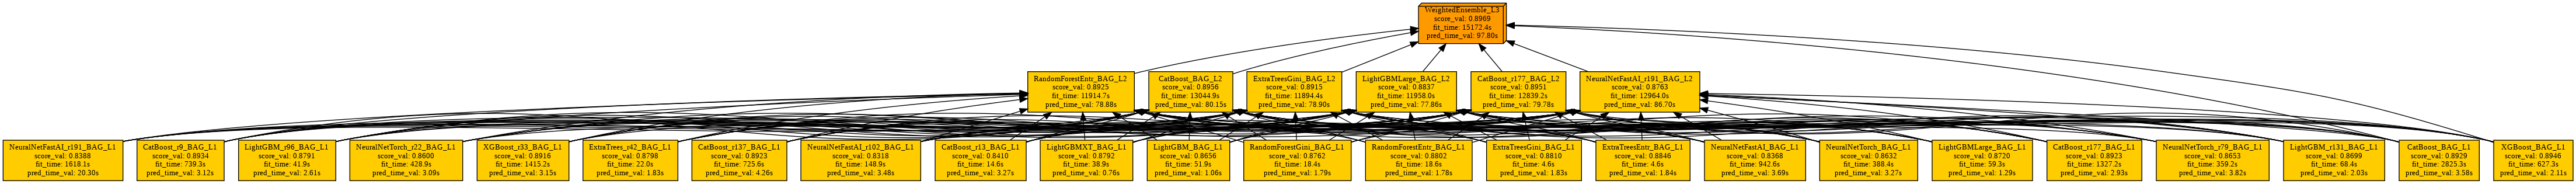

In [19]:
predictor.plot_ensemble_model(filename='ensemble_model.png')
display(Image('./AG_loan_models/ensemble_model.png'))

In [20]:
# !zip -r /kaggle/working/AG_accident_models /kaggle/working/AG_accident_models.zip
# !zip -r {FOLDER}{NAME_EXT}.zip /kaggle/working/{FOLDER}{NAME_EXT}

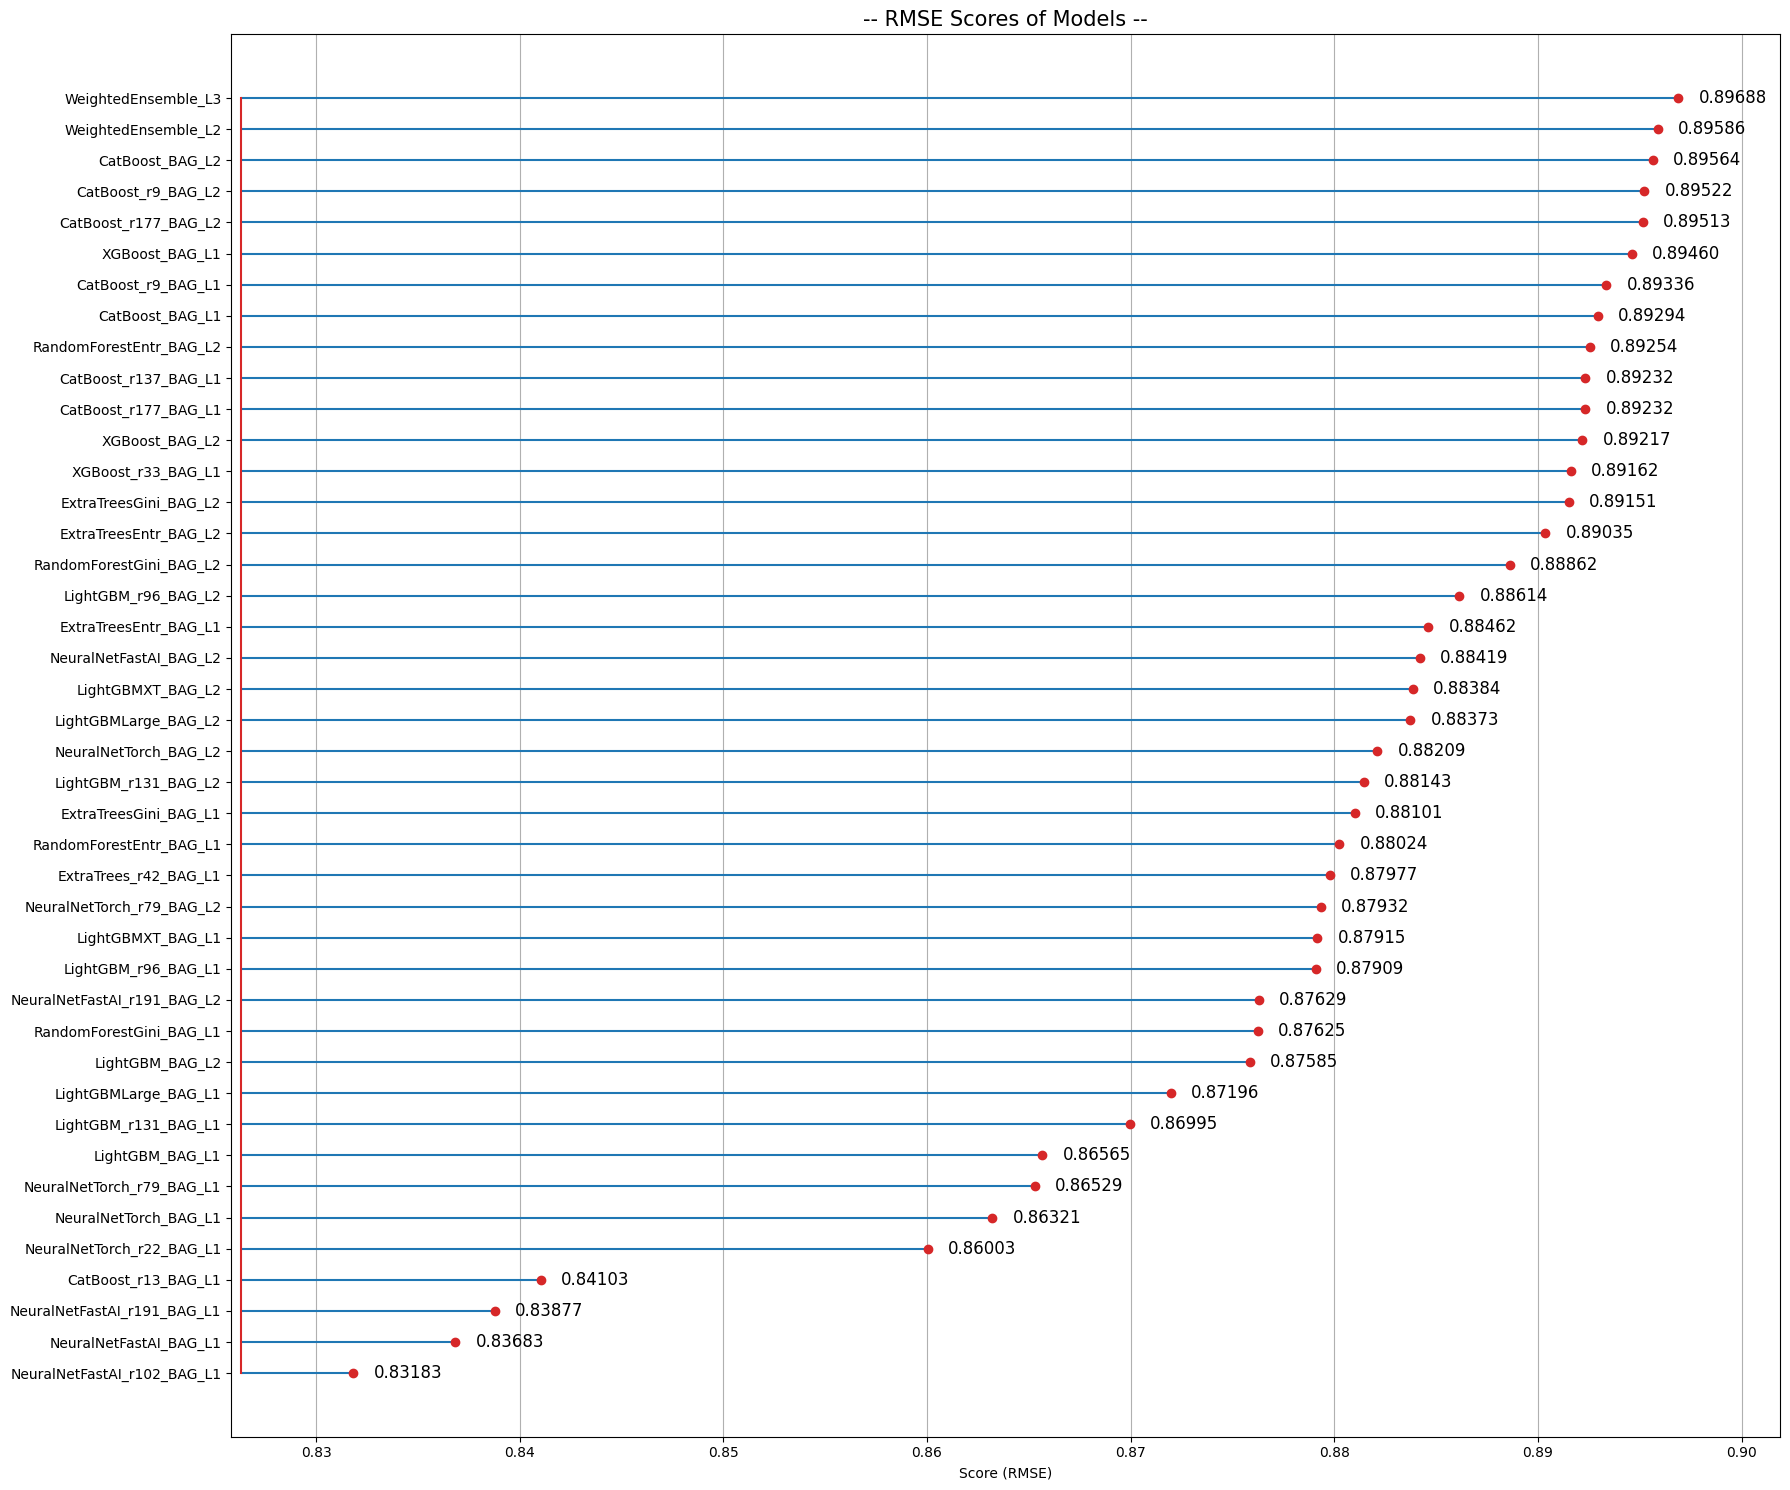

In [21]:
## -- Extract model scores --
result_ = dict(zip(leaderboard['model'], leaderboard['score_val']))
result_df = pd.DataFrame.from_dict(result_, orient='index').sort_values(0)

max_score = result_df.max().item()
min_score = result_df.min().item()

## -- PLOT MODELS & SCORES --
plt.figure(figsize=(18, 15))
plt.stem(
    result_df.index,
    result_df[0],
    orientation = 'horizontal',
    bottom = min_score - 0.0055,
    markerfmt = 'C3o'
)
plt.xlim(min_score - 0.006, max_score + 0.005)
plt.xlabel('Score (RMSE)')
plt.title('-- RMSE Scores of Models --', fontsize=15)

for i, value in enumerate(result_df[0]):
    plt.text(value+1e-3, i, f'{abs(value):.5f}', ha='left', va='center', fontdict=dict(size=12))

plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [22]:
# predictor.model_names()

In [23]:
# ## -- Permutation Feature Importances --
# feat_imp = predictor.feature_importance(
#                         data = X_test,
#                         # time_limit = 3600,
#                         # model = 'LightGBM_BAG_L1',
#                         # features = None,
#                         # feature_stage = 'transformed',
#                         # subsample_size = 5000,
#                         # num_shuffle_sets = 10,
#                         # include_confidence_band = True,
#                         confidence_level = 0.95,
#                         # silent = False
# ) 

# feat_imp.style.background_gradient(subset=["importance"], cmap="Spectral")

In [24]:
# plt.figure(figsize=(18, 35))
# sns.barplot(data=feat_imp, y=feat_imp.index, x=feat_imp.importance)
# plt.tick_params(axis='y', which='major', labelcolor='r')
# plt.title("Top Features by Permutation")
# plt.tight_layout()
# plt.show()

In [25]:
## -- OPTIONAL: Remove stored files --
!rm -r /kaggle/working/AG_loan_models

In [26]:
print(f"""
{'-'*48}
{'█'*5} | - AUTOGLUON NOTEBOOK COMPLETE! - | {'█'*5}
{'-'*48}
""")


------------------------------------------------
█████ | - AUTOGLUON NOTEBOOK COMPLETE! - | █████
------------------------------------------------

